In [13]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [14]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from common.processor.utils import Utils
from common.extractor.alpaca_extractor import AlpacaExtractor
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio import Portfolio
import numpy as np
import matplotlib.pyplot as plt

In [15]:
## Import standard packages
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [16]:
orivault = ADatabase("ori")
alp = AlpacaExtractor(paper=False)

In [ ]:
orivault.connect()
portfolio_dictionary = orivault.retrieve("results").to_dict("records")[0]
orivault.disconnect()

In [ ]:
pm = Portfolio.from_dict(portfolio_dictionary)

In [19]:
## Retrieve existing stocks 
index = alp.assets().sort_values("ticker")
tickers = index["ticker"].values
tickers_per_batch = int(1000)
batchs = [tickers[i:i + tickers_per_batch] for i in range(0, len(tickers), tickers_per_batch)]
bars = []
[bars.append(alp.latest_bars_bulk(batch)) for batch in batchs]
todays_bar = pd.concat(bars)
index = index.merge(todays_bar,on="ticker",how="left")

'SVA'
'WTGUU'


In [20]:
end = Utils.last_weekday(alp.clock())
start = (end - timedelta(days=pm.rolling_window*3))
print(start,end)

2025-04-27 16:00:00-04:00 2025-05-27 16:00:00-04:00


In [21]:
tickers_per_batch = int(10000/(pm.rolling_window*4)/5)
print(tickers_per_batch)

50


In [25]:
relevant_tickers = index["ticker"]
batchs = [relevant_tickers[i:i + tickers_per_batch] for i in range(0, len(relevant_tickers), tickers_per_batch)]

In [49]:
prices = []
for batch in tqdm(batchs):
    try:
        tickers_data = alp.prices_bulk(batch,start,end)
        for ticker in batch:
            try:
                price = tickers_data[tickers_data["ticker"] == ticker].copy()
                price = p.lower_column(price)
                price = p.utc_date(price)
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                price["market_cap"] = price["adjclose"] * price["volume"]
                price["standard_dev"] = 1
                price["coefficient_of_variation"] = 1
                price["dividend"] = 0
                for member in Metric:
                    price = member.calculate(price,timeframe=pm.rolling_window,live=True)
                for member in Indicator:
                    price = member.calculate(price,timeframe=pm.rolling_window,live=True)
                prices.append(price)
            except Exception as e:
                print(str(e))
    except Exception as e:
        print(str(e))

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 192/226 [06:38<01:11,  2.09s/it]

'SVA'
index 0 is out of bounds for axis 0 with size 0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 218/226 [07:33<00:16,  2.05s/it]

'WTGUU'
index 0 is out of bounds for axis 0 with size 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [07:49<00:00,  2.08s/it]


In [50]:
simulation = pd.concat(prices)
simulation.sort_values("date", inplace=True)
trades = pm.recs(simulation.copy())
trades

,year,day,ticker,date,adjclose,high,low,volume,month,quarter,...,williams_r,obv,vwap,market_impact,atr,group_percentile,rank_percentile,major_key,position_type,weight
10,2025,147,CGBS,2025-05-27 00:00:00+00:00,0.058,0.0701,0.0579,11130524,5,2,...,-99.910794,-73947543.0,0.086357,3.221785e+06,0.02244,1,556,2025_147_1,1.0,1.0


In [93]:
ori = ADatabase("ori")
ori.connect()
ams = ori.retrieve("ams")
ori.disconnect()
dropped_columns = ["year","quarter","month","week","day","weekday","coefficient_of_variation","dividend","optimal"]
dropped_columns.extend([x for x in simulation.columns if "test" in x])
todays_view = simulation[simulation["date"]==simulation["date"].max()].drop(dropped_columns,axis=1).copy()
todays_view = todays_view.merge(ams[["ticker","NAME_OF_ISSUER","SHARE_VALUE","share_price"]],on="ticker",how="inner")
todays_view["pb"] = todays_view["adjclose"] / todays_view["share_price"] - 1
todays_view["weight"] = todays_view["SHARE_VALUE"]/todays_view["SHARE_VALUE"].sum()
todays_view["return"] = todays_view["pb"] * todays_view["weight"]

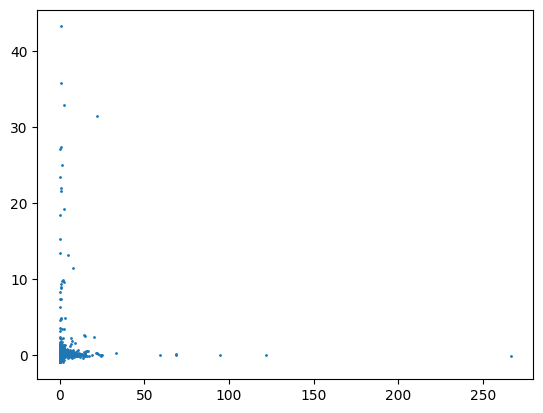

In [102]:
plt.scatter(todays_view["standard_dev"],todays_view["pb"],s=1)
plt.show()

In [101]:
winsored = todays_view.sort_values("pb",ascending=True).iloc[200:-200].round(4)
winsored.sort_values("return",ascending=False).head(20)

,date,adjclose,high,low,volume,ticker,market_cap,standard_dev,average_return,rolling_dollar_volume,...,obv,vwap,market_impact,atr,NAME_OF_ISSUER,SHARE_VALUE,share_price,pb,weight,return
2163,2025-05-27 00:00:00+00:00,460.69,460.950,456.1150,20974293,MSFT,9.662647e+09,3.9285,0.0200,9.141171e+09,...,50920272.0,454.2369,2.638976e+05,5.7176,MICROSOFT CORP,4.325658e+10,375.39,0.2272,0.0676,0.0154
1935,2025-05-27 00:00:00+00:00,135.50,135.660,133.3100,192953613,NVDA,2.614521e+10,2.0667,0.0675,3.029084e+10,...,554028652.0,133.4879,5.488248e+06,3.7854,NVIDIA CORPORATION,3.395358e+10,108.38,0.2502,0.0531,0.0133
1412,2025-05-27 00:00:00+00:00,235.65,236.480,231.1308,17941668,AVGO,4.227954e+09,2.1130,0.0553,4.230854e+09,...,31144094.0,231.3291,5.499586e+05,7.0894,BROADCOM INC,1.331683e+10,167.43,0.4075,0.0208,0.0085
1547,2025-05-27 00:00:00+00:00,362.89,363.790,347.3200,120146414,TSLA,4.359993e+10,8.3533,0.0940,3.758982e+10,...,345098770.0,344.0328,4.722980e+06,13.4963,TESLA INC,9.140488e+09,259.16,0.4003,0.0143,0.0057
1801,2025-05-27 00:00:00+00:00,1211.57,1211.770,1193.0900,2920469,NFLX,3.538353e+09,21.7050,0.0250,3.774920e+09,...,23905899.0,1179.5873,5.568403e+04,22.4207,NETFLIX INC,5.905597e+09,932.53,0.2992,0.0092,0.0028
789,2025-05-27 00:00:00+00:00,265.29,265.300,261.9900,7506555,JPM,1.991414e+09,2.6681,0.0195,2.224546e+09,...,31871104.0,264.4570,1.266107e+05,4.4544,JPMORGAN CHASE & CO.,1.115283e+10,245.30,0.0815,0.0174,0.0014
1991,2025-05-27 00:00:00+00:00,1027.39,1029.830,1012.9801,1102507,NOW,1.132705e+09,11.0880,0.0174,1.311924e+09,...,-1618327.0,1024.9210,1.927202e+04,17.9021,SERVICENOW INC,2.587056e+09,796.14,0.2905,0.0040,0.0012
2169,2025-05-27 00:00:00+00:00,97.58,97.795,96.5800,17180937,WMT,1.676516e+09,0.9040,-0.0035,2.125114e+09,...,-38662610.0,96.9954,3.909537e+05,2.2073,WALMART INC,6.232520e+09,87.79,0.1115,0.0097,0.0011
208,2025-05-27 00:00:00+00:00,241.78,242.280,235.1000,7162378,GE,1.731720e+09,5.8947,0.0492,1.290613e+09,...,24092308.0,231.3126,1.488700e+05,4.8274,GE AEROSPACE,3.019177e+09,200.15,0.2080,0.0047,0.0010
1475,2025-05-27 00:00:00+00:00,89.00,89.715,87.8900,17446940,UBER,1.552778e+09,1.7449,0.0280,2.049378e+09,...,-36054366.0,90.3553,4.873117e+05,2.5281,UBER TECHNOLOGIES INC,2.718057e+09,72.86,0.2215,0.0042,0.0009


In [97]:
winsored["return"].sum()

np.float64(0.05277506253581098)